<br>

<div align=center><font color=maroon size=6><b>(beta) Quantized Transfer Learning for Computer Vision Tutorial</b></font></div>

<br>

<font size=4><b>References:</b></font>
1. Pytorch official tutorials: <a href="https://pytorch.org/tutorials/index.html" style="text-decoration:none;">WELCOME TO PYTORCH TUTORIALS</a> 
    * Tutorials > <a href="https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html" style="text-decoration:none;">(beta) Quantized Transfer Learning for Computer Vision Tutorial</a>
    * Docs > <a href="" style="text-decoration:none;"></a>

<br>
<br>
<br>

<div class="alert alert-block alert-info">

<font size=3 color=red><b>NOTE: </b></font>
<br>
<br>
To get the most of this tutorial, we suggest using this <a href="https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/quantized_transfer_learning_tutorial.ipynb" style="text-decoration:none;color:maroon;font-size:120%;">Colab Version</a>. This will allow you to experiment with the information presented below.

</div>

<br>
<br>

**Author:** <a href="https://github.com/z-a-f" style="text-decoration:none;color:maroon;font-size:120%;">Zafar Takhirov</a>

**Reviewed by:** <a href="https://github.com/raghuramank100" style="text-decoration:none;color:maroon;font-size:120%;">Raghuraman Krishnamoorthi</a>

**Edited by:** <a href="https://github.com/jlin27" style="text-decoration:none;color:maroon;font-size:120%;">Jessica Lin</a>

This tutorial builds on the original <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html" style="text-decoration:none;color:maroon;font-size:120%;">PyTorch Transfer Learning tutorial</a>, written by <a href="https://chsasank.github.io/" style="text-decoration:none;color:maroon;font-size:120%;">Sasank Chilamkurthy</a>.

<br>
<br>
<br>

<font size=3>Transfer learning refers to techniques that make use of a pretrained model for application on a different data-set. There are two main ways the transfer learning is used:

* <font color=maroon>**ConvNet as a fixed feature extractor:**</font> Here, you <a href="https://arxiv.org/abs/1706.04983" style="text-decoration:none;color:maroon;">“freeze”</a> the weights of all the parameters in the network except that of the final several layers (aka “the head”, usually fully connected layers). These last layers are replaced with new ones initialized with random weights and only these layers are trained.


* <font color=maroon>**Finetuning the ConvNet:**</font> Instead of random initializaion, the model is initialized using a pretrained network, after which the training proceeds as usual but with a different dataset. Usually the head (or part of it) is also replaced in the network in case there is a different number of outputs. <font color=maroon>It is common in this method to set the learning rate to a smaller number. This is done because the network is already trained, and only minor changes are required to “finetune” it to a new dataset.</font>


<font color=red>**You can also combine the above two methods:**</font> First you can freeze the feature extractor, and train the head. After that, you can unfreeze the feature extractor (or part of it), set the learning rate to something smaller, and continue training.</font>


<font size=3>In this part you will use the first method – extracting the features using a quantized model.</font>

<br>
<br>
<br>

# Part 0. Prerequisites <a href="https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html#part-0-prerequisites" style="text-decoration:none;font-size:70%">[link]</a>

Before diving into the transfer learning, let us review the “prerequisites”, such as installations and data loading/visualizations.

In [1]:
# Imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()

<br>
<br>

## Installing the Nightly Build <a href="https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html#installing-the-nightly-build" style="text-decoration:none;font-size:70%">[link]</a>

`(详见原网址)`

<br>
<br>
<br>

## Load Data <a href="https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html#load-data" style="text-decoration:none;font-size:70%">[link]</a>

<div class="alert alert-block alert-info">

<font size=3 color=red><b>NOTE: </b></font>
<br>
<br>
This section is identical to the original transfer learning tutorial.

</div>

We will use `torchvision` and `torch.utils.data` packages to load the data.

The problem you are going to solve today is classifying **ants** and **bees** from images. The dataset contains about 120 training images each for ants and bees. There are 75 validation images for each class. This is considered a very small dataset to generalize on. However, since we are using transfer learning, we should be able to generalize reasonably well.

*This dataset is a very small subset of imagenet.*

<div class="alert alert-block alert-info">

<font size=3 color=red><b>NOTE: </b></font>
<br>
<br>
Download the data from <a href="https://download.pytorch.org/tutorial/hymenoptera_data.zip" style="text-decoration:none;color:maroon;font-size:120%;">here</a> and extract it to the `data` directory.

</div>

In [2]:
import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = { 'train': transforms.Compose([
                             transforms.Resize(224),
                             transforms.RandomCrop(224),
                             transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], 
                                                  [0.229, 0.224, 0.225]) ]),
                     'val': transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                 [0.229, 0.224, 0.225]) ]),
                   }

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                     for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=16,
                                              shuffle=True, 
                                              num_workers=4)
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<br>
<br>

## Visualize a few images <a href="https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html#visualize-a-few-images" style="text-decoration:none;color:maroon;font-size:120%;"></a>

Let’s visualize a few training images so as to understand the data augmentations.

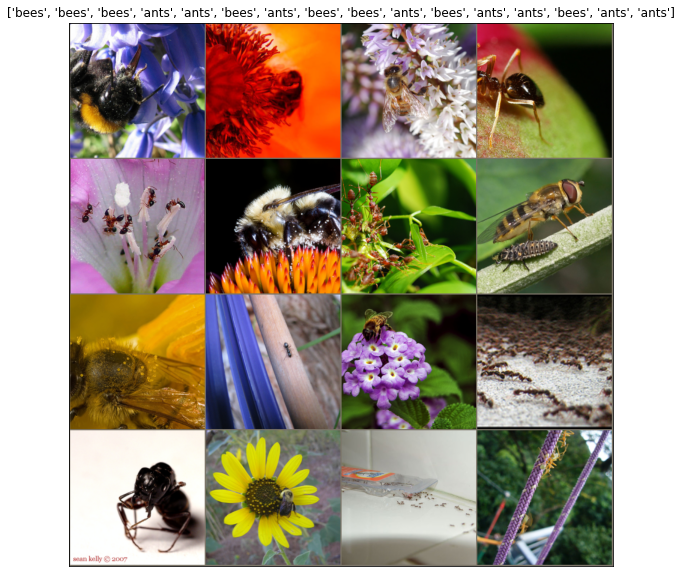

In [3]:
import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(inp)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4) # 前面 batch_size 设置为 16, 故 这里 make_gird 将会有四列。

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

<br>
<br>

## Support Function for Model Training <a href="https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html#support-function-for-model-training" style="text-decoration:none;font-size:70%">[link]</a>

Below is a generic function for model training. This function also

* Schedules the learning rate
* Saves the best model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        # each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)   # dim=0 应该是 batch dimension
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

<br>
<br>

## Support Function for Visualizing the Model Predictions <a href="https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html#support-function-for-visualizing-the-model-predictions" style="text-decoration:none;font-size:70%">[link]</a>

Generic function to display predictions for a few images

In [5]:
def visualize_model(model, rows=3, cols=3):
    was_training = model.training
    model.eval()
    current_row = current_col = 0
    fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

    with torch.no_grad():
        for idx, (imgs, lbls) in enumerate(dataloaders['val']):
            imgs = imgs.cpu()
            lbls = lbls.cpu()

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

        for jdx in range(imgs.size()[0]):
            imshow(imgs.data[jdx], ax=ax[current_row, current_col])
            ax[current_row, current_col].axis('off')
            ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

            current_col += 1
            if current_col >= cols:
                current_row += 1
                current_col = 0
            if current_row >= rows:
                model.train(mode=was_training)
                return
    
    model.train(mode=was_training)

<br>
<br>
<br>

# Part 1. Training a Custom Classifier based on a <font color=maroon>**Quantized Feature Extractor**</font> <a href="https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html#part-1-training-a-custom-classifier-based-on-a-quantized-feature-extractor" style="text-decoration:none;font-size:70%">[link]</a>

<br>

<font size=3>In this section you will use a “frozen” quantized feature extractor, and train a custom classifier head on top of it. <font color=maroon>Unlike floating point models, you don’t need to set `requires_grad=False` for the quantized model, as it has no trainable parameters. Please, refer to the <a href="https://pytorch.org/docs/stable/quantization.html" style="text-decoration:none;color:maroon;font-size:120%;">**documentation**</a> `Docs > Quantization` for more details.</font>

Load a pretrained model: for this exercise you will be using <a href="https://pytorch.org/hub/pytorch_vision_resnet/" style="text-decoration:none;color:maroon;font-size:120%;">ResNet-18</a>.</font>


In [6]:
import torchvision.models.quantization as models

# You will need the number of filters in the `fc` for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

D:\Programs\Anaconda3\envs\ptg\lib\site-packages\torch\ao\quantization\observer.py:172: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


<br>

<font size=3>At this point you need to modify the pretrained model. <font color=maroon>The model has the **quantize/dequantize** blocks in the beginning and the end.</font> However, because you will only use the feature extractor, the dequantization layer has to move right before the linear layer (the head). The easiest way to do that is to wrap the model in the `nn.Sequential` module.

<font color=maroon>The first step is to isolate the feature extractor in the **ResNet** model. Although in this example you are tasked to use all layers except `fc` as the feature extractor, in reality, you can take as many parts as you need. This would be useful in case you would like to replace some of the convolutional layers as well.</font></font>

<div class="alert alert-block alert-info">

<font size=3 color=red><b>NOTE: </b></font>
<br>
<br>
When separating the feature extractor from the rest of a quantized model, you have to manually place the quantizer/dequantized in the beginning and the end of the parts you want to keep quantized.

</div>

<br>

<font size=3>The function below creates a model with a custom head.</font>


In [7]:
from torch import nn

def create_combine_model(model_fe):
    # Step 1. Isolate the feature extractor.
    model_fe_features = nn.Sequential(model_fe.quant,  # Quantize the input
                                      model_fe.conv1,
                                      model_fe.bn1,
                                      model_fe.relu,
                                      model_fe.maxpool,
                                      model_fe.layer1,
                                      model_fe.layer2,
                                      model_fe.layer3,
                                      model_fe.layer4,
                                      model_fe.avgpool,
                                      model_fe.dequant, # Dequantize the output
                                      )
    
    # Step 2. Create a new "head"
    new_head = nn.Sequential(nn.Dropout(p=0.5),
                             nn.Linear(num_ftrs, 2))
    
    
    # Step 3. Combine, and don't forget the quant stubs.
    new_model = nn.Sequential(model_fe_features, 
                              nn.Flatten(1),
                              new_head,
                              )
    
    return new_model

<br>

<div class="alert alert-block alert-danger">

<font size=3 color=red><b>WARNING: </b></font>
<br>
<br>
Currently the quantized models can only be run on CPU. However, it is possible to send the non-quantized parts of the model to a GPU.

</div>

In [8]:
import torch.optim as optim

new_model = create_combine_model(model_fe)
# new_model = new_model.to(device)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

<br>
<br>

## Train and evaluate <a href="https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html#train-and-evaluate" style="text-decoration:none;font-size:70%">[link]</a>

This step takes around 15-25 min on CPU. Because the quantized model can only run on the CPU, you cannot run the training on GPU.

Epoch 1/25
----------
train Loss: 0.4812 Acc: 0.7869
val Loss: 0.2149 Acc: 0.9216

Epoch 2/25
----------
train Loss: 0.3570 Acc: 0.9098
val Loss: 0.2175 Acc: 0.9412

Epoch 3/25
----------
train Loss: 0.4496 Acc: 0.8852
val Loss: 0.2666 Acc: 0.9412

Epoch 4/25
----------
train Loss: 0.3570 Acc: 0.9303
val Loss: 0.2267 Acc: 0.9477

Epoch 5/25
----------
train Loss: 0.4219 Acc: 0.9139
val Loss: 0.2350 Acc: 0.9477

Epoch 6/25
----------
train Loss: 0.4324 Acc: 0.9016
val Loss: 0.3485 Acc: 0.9477

Epoch 7/25
----------
train Loss: 0.3347 Acc: 0.9180
val Loss: 0.5100 Acc: 0.9085

Epoch 8/25
----------
train Loss: 0.2864 Acc: 0.9385
val Loss: 0.3053 Acc: 0.9346

Epoch 9/25
----------
train Loss: 0.1812 Acc: 0.9590
val Loss: 0.2849 Acc: 0.9477

Epoch 10/25
----------
train Loss: 0.2363 Acc: 0.9426
val Loss: 0.2813 Acc: 0.9477

Epoch 11/25
----------
train Loss: 0.1891 Acc: 0.9467
val Loss: 0.2885 Acc: 0.9477

Epoch 12/25
----------
train Loss: 0.2823 Acc: 0.9426
val Loss: 0.2901 Acc: 0.9412

E

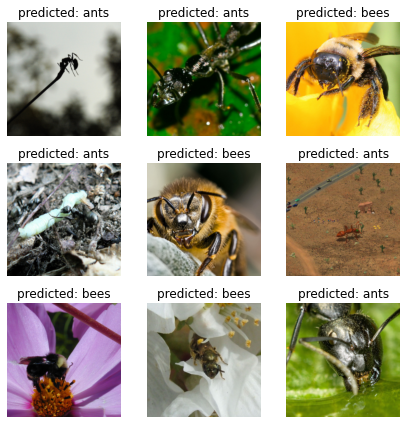

In [9]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25, device='cpu')

visualize_model(new_model)
plt.tight_layout()

<br>
<br>
<br>

# Part 2. <font color=maroon>**Finetuning**</font> the Quantizable Model <a href="https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html#part-2-finetuning-the-quantizable-model" style="text-decoration:none;font-size:70%">[link]</a>

<font size=3>In this part, we fine tune the feature extractor used for transfer learning, and quantize the feature extractor. **Note that** in both part 1 and 2, the feature extractor is quantized. The difference is that in part 1, we use a pretrained quantized model. In this part, we create a quantized feature extractor after fine tuning on the data-set of interest, so this is a way to get better accuracy with transfer learning while having the benefits of quantization. 


**Note that** in our specific example, the training set is really small (120 images) so the benefits of fine tuning the entire model is not apparent. However, the procedure shown here will improve accuracy for transfer learning with larger datasets.</font>

<br>

<font size=3 color=maroon>The pretrained feature extractor **must be quantizable**. To make sure it is quantizable, perform the following steps:

1. Fuse `(Conv, BN, ReLU)`, `(Conv, BN)`, and `(Conv, ReLU)` using `torch.quantization.fuse_modules`.

    
2. Connect the feature extractor with a custom head. This requires dequantizing the output of the feature extractor.

    
3. Insert fake-quantization modules at appropriate locations in the feature extractor to mimic quantization during training.</font>

<font size=3><br>
* For step (1), we use **models** from `torchvision/models/quantization`, which have a <font color=maroon>member method</font> `fuse_model`. This function fuses all the `conv`, `bn`, and `relu` modules. For custom models, this would require calling the `torch.quantization.fuse_modules` API with the list of modules to fuse manually.
<br><br>
* Step (2) is performed by the `create_combined_model` function used in the previous section.
<br><br>
* Step (3) is achieved by using `torch.quantization.prepare_qat`, which inserts fake-quantization modules.
<br><br>
* As step (4), you can start “finetuning” the model, and after that convert it to a fully quantized version (Step 5).
<br><br>
* To convert the fine tuned model into a quantized model you can call the `torch.quantization.convert `function (in our case only the feature extractor is quantized).

</font>


<div class="alert alert-block alert-info">

<font size=3 color=red><b>NOTE: </b></font>
<br>
<br>
Because of the random initialization your results might differ from the results shown in this tutorial.

</div>

In [11]:
# notice `quantize = False`
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

# Step 1
model.train()
model.fuse_model()

# Step 2
model_ft = create_combine_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # Use default QAT configuration

# Step 3
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

D:\Programs\Anaconda3\envs\ptg\lib\site-packages\torch\ao\quantization\observer.py:172: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


<br>
<br>

## Finetuning the model <a href="https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html#finetuning-the-model" style="text-decoration:none;font-size:70%">[link]</a>

In the current tutorial the whole model is fine tuned. In general, this will lead to higher accuracy. However, due to the small training set used here, we end up overfitting to the training set.

**Step 4**. Fine tune the model

In [14]:
# Step 4. Fine tune the model
for param in model_ft.parameters():
    param.requires_grad = True


device = "cuda:0" if torch.cuda.is_available() else 'cpu'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)


model_ft_tuned = train_model(model_ft, 
                             criterion,
                             optimizer_ft, 
                             exp_lr_scheduler,
                             num_epochs = 25,
                             device=device)

Epoch 1/25
----------
train Loss: 0.5965 Acc: 0.6803
val Loss: 0.2987 Acc: 0.9216

Epoch 2/25
----------
train Loss: 0.3451 Acc: 0.8648
val Loss: 0.2027 Acc: 0.9281

Epoch 3/25
----------
train Loss: 0.1923 Acc: 0.9180
val Loss: 0.1822 Acc: 0.9346

Epoch 4/25
----------
train Loss: 0.1977 Acc: 0.9385
val Loss: 0.1624 Acc: 0.9542

Epoch 5/25
----------
train Loss: 0.1938 Acc: 0.9221
val Loss: 0.2107 Acc: 0.9281

Epoch 6/25
----------
train Loss: 0.1201 Acc: 0.9590
val Loss: 0.1650 Acc: 0.9477

Epoch 7/25
----------
train Loss: 0.1009 Acc: 0.9713
val Loss: 0.1413 Acc: 0.9346

Epoch 8/25
----------
train Loss: 0.0608 Acc: 0.9836
val Loss: 0.1485 Acc: 0.9346

Epoch 9/25
----------
train Loss: 0.0810 Acc: 0.9713
val Loss: 0.1692 Acc: 0.9477

Epoch 10/25
----------
train Loss: 0.0969 Acc: 0.9754
val Loss: 0.1511 Acc: 0.9477

Epoch 11/25
----------
train Loss: 0.0922 Acc: 0.9631
val Loss: 0.1686 Acc: 0.9542

Epoch 12/25
----------
train Loss: 0.0545 Acc: 0.9877
val Loss: 0.1632 Acc: 0.9477

E

<br>

**Step 5**. Convert to quantized model

In [16]:
# Step 5. Convert to quantized model
from torch.quantization import convert

In [17]:
model_ft_tuned.cpu()
model_quantized_and_trained = convert(model_ft_tuned, inplace=False)

<br>

Lets see how the quantized model performs on a few images

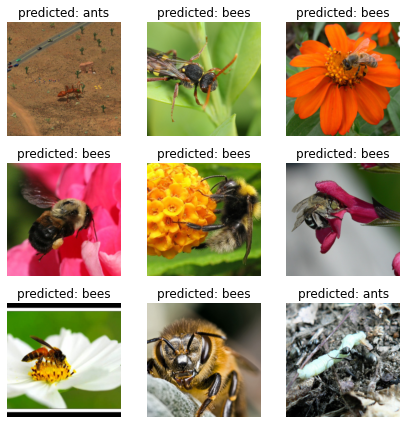

In [18]:
visualize_model(model_quantized_and_trained)

plt.ioff()
plt.tight_layout()
plt.show()

<br>
<br>

<font style="font-size:120%;LINE-HEIGHT: 30px">
<font color=red><b>代码学习：</b></font><br>

```python

```

</font>

<br>
<br>
<br>